In [1]:
%matplotlib inline
import d2lzh as d2l
import torch
from torch.nn import init
from torch import nn
from torch import optim
from torch.utils import data

In [2]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
features = torch.randn((n_train + n_test, num_inputs))
labels = features @ true_w + true_b
labels += torch.randn(labels.shape) * 0.01
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [3]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [5]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = data.DataLoader(data.TensorDataset(train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y.view(-1, 1)) + lambd * l2_penalty(w)
            if w.grad is not None:
                w.grad.zero_()
            if b.grad is not None:
                b.grad.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),
                             train_labels).sum().item())
        test_ls.append(loss(net(test_features, w, b),
                            test_labels).sum().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 12.367249488830566


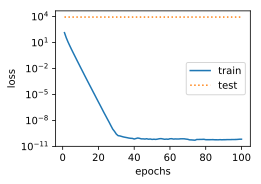

In [6]:
fit_and_plot(lambd=0)

L2 norm of w: 0.0334075428545475


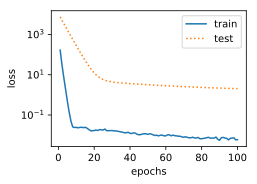

In [7]:
fit_and_plot(lambd=3)

In [8]:
def fit_and_plot_torch(wd):
    net = nn.Linear(200, 1)
    init.normal_(net.weight)
    # 对权重参数衰减。权重名称一般是以weight结尾
    optimizer_w = optim.SGD([net.weight], lr=lr, weight_decay=wd)
    optimizer_b = optim.SGD([net.bias], lr=lr)
    # 不对偏差参数衰减。偏差名称一般是以bias结尾
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y)
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            # 对两个Trainer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),
                             train_labels).mean().item())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.norm().data)

L2 norm of w: tensor(12.6812)


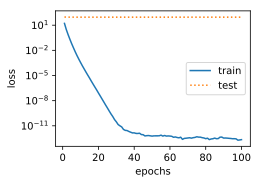

In [9]:
fit_and_plot_torch(0)

L2 norm of w: tensor(0.0315)


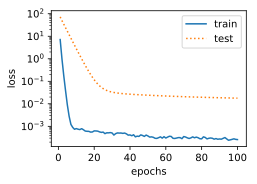

In [10]:
fit_and_plot_torch(3)